# Przewidywanie zużycia energii z tensorflow 2.4

In [254]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

### Niezbędne biblioteki

In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [127]:
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import preprocessing

### Importowanie danych

In [4]:
data_date = pd.read_csv("daily_weather_and_energy_consumption.csv")

In [5]:
data_date.head()

,Data,Temperatura,Wilogtność powietrza,Prędkość wiatru,Zachmurzenie,Dobowa prognoza zapotrzebowania KSE,Rzeczywiste zapotrzebowanie KSE
0,2015-01-01,-0.77,31.80,1.34,7.57,NaN,15098.40
1,2015-01-02,1.27,29.94,2.47,6.83,17822.96,17869.20
2,2015-01-03,1.87,28.00,2.80,6.95,17639.33,17684.92
3,2015-01-04,0.42,28.89,2.79,6.27,16235.42,16453.76
4,2015-01-05,-1.03,29.75,1.91,6.05,18892.71,18856.44


Jako, że zapotrzebowanie intuicyjnie może zależeć od miesiąca (grudzień vs czerwiec), ale nie od samego roku (np. 2016 bo sama ta informacja nie wystarcza, żeby coś wnioskować), zamieniam kolumnę <b>Data</b> na procent roku (co koreluje z porą roku)

In [6]:
def date_to_double(dateS, form):
    d = datetime.strptime(dateS, form)
    
    beg = datetime(d.year,1,1,0,0,0)
    end = datetime(d.year,12,31,23,59,59)
    
    sec = (d-beg).total_seconds()
    
    return sec / (end-beg).total_seconds()

In [7]:
data = data_date.copy()
data["Data"] = data["Data"].map(lambda d: date_to_double(d, "%Y-%m-%d"))
data = data.drop(['Dobowa prognoza zapotrzebowania KSE'], axis=1)

data.dropna()
data.head()

,Data,Temperatura,Wilogtność powietrza,Prędkość wiatru,Zachmurzenie,Rzeczywiste zapotrzebowanie KSE
0,0.000000,-0.77,31.80,1.34,7.57,15098.40
1,0.002740,1.27,29.94,2.47,6.83,17869.20
2,0.005479,1.87,28.00,2.80,6.95,17684.92
3,0.008219,0.42,28.89,2.79,6.27,16453.76
4,0.010959,-1.03,29.75,1.91,6.05,18856.44


Dane należy podzielić na dane wejściowe i wyjściowe

In [334]:
features = data_norm.loc[0:,'Data':'Zachmurzenie']
labels   = data_norm.loc[0:, 'Rzeczywiste zapotrzebowanie KSE']

oraz na zbiór uczący i zbiór testowy

In [378]:
features_train = features.sample(frac=0.8, random_state=200)
features_test  = features.drop(features_train.index).reset_index(drop=True)

labels_train   = labels.sample(frac=0.8, random_state=200)
labels_test    = labels.drop(labels_train.index).reset_index(drop=True)

In [336]:
features.head()

,Data,Temperatura,Wilogtność powietrza,Prędkość wiatru,Zachmurzenie
0,0.000000,-0.77,31.80,1.34,7.57
1,0.002740,1.27,29.94,2.47,6.83
2,0.005479,1.87,28.00,2.80,6.95
3,0.008219,0.42,28.89,2.79,6.27
4,0.010959,-1.03,29.75,1.91,6.05


In [337]:
labels.head()

0    15098.40
1    17869.20
2    17684.92
3    16453.76
4    18856.44
Name: Rzeczywiste zapotrzebowanie KSE, dtype: float64

### Definiowanie warstw

In [356]:
leaky_relu_alpha = 0.2
learning_rate = 0.003

def dense( inputs , weights ):
    '''
        tf.nn.leaky_relu: Leaky version of a Rectified Linear Unit.
                          A leaky ReLU layer performs a threshold operation, 
                          where any input value less than zero is multiplied by a fixed scalar.
        tf.nn.dropout:    Computes dropout: randomly sets elements to zero to prevent overfitting.
        tf.matmul:        Multiplies matrix a by matrix b, producing a * b.
    '''
    x = tf.nn.leaky_relu( tf.matmul( inputs , weights ) , alpha=leaky_relu_alpha )
    return x #tf.nn.dropout( x , rate=dropout_rate )

### Inicializowanie sieci

In [367]:
# Initialiser creates tensor of numbers with uniform distribution
initializer = tf.initializers.glorot_uniform()

def get_weight( shape , name ):
    # tf.Variable changes a tensor into a variable
    return tf.Variable( initializer( shape ) , name=name , trainable=True , dtype=tf.float32 )

<i><b>shapes</b></i> tutaj oznacza, że warstwy gęste mają kolejno 5, 20, 10, 10 i 1 neuronów

In [385]:
shapes = [
    [ 5 , 10 ] , 
    [ 10 , 1 ] ,
]

weights = []
for i in range( len( shapes ) ):
    weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )

### Tworzenie modelu
Składa się on z warstwy wejściowej, kilku warstw gęstych i warstwy wyjściowej

In [341]:
def model( x ) :
    x = tf.cast( x , dtype=tf.float32 ) # Element-wise cast to float32
    
    d1 = dense(  x , weights[ 0 ] )
    
    logits = tf.matmul( d1 , weights[ 1 ] )
    
    return logits #tf.nn.softmax( logits ) # softmax activations

### Uczenie modelu

funkcja błędu

In [342]:
def loss( pred , target ):
    return tf.losses.mean_squared_error( target , pred )

In [343]:
optimizer = tf.optimizers.Adam( learning_rate )

def train_step( model, inputs , outputs ):
    with tf.GradientTape() as tape:
        current_loss = loss( model( inputs ), outputs)
    grads = tape.gradient( current_loss , weights )
    optimizer.apply_gradients( zip( grads , weights ) )
    return np.matrix(current_loss)[0,0]

In [386]:
from statistics import mean

num_epochs = 20
error_batch_size = 10

errors_train = []
errors_test= []

batch_err_train = []
batch_err_test = []

for e in range( num_epochs ):
    i=0
    for feature_train, label_train in zip(features_train.iloc, labels_train):
        
        batch_err_train.append( train_step( model , np.matrix(feature_train.values) , np.matrix(label_train) ))
        
        if len(batch_err_train) == len(labels_train) // error_batch_size:
            errors_train.append( mean(batch_err_train) )
            batch_err_train = []
           
        j = len(labels_test) * i // len(labels_train)
        if i % (len(labels_train) // len(labels_test)) == 0:
            feature_test, label_test = features_test.iloc[j], labels_test[j]
            
            batch_err_test.append( np.matrix(loss( model(np.matrix(feature_test.values)), np.matrix(label_test) ))[0,0])
            if len(batch_err_test) == len(labels_test) // error_batch_size:
                errors_test.append(mean(batch_err_test))
                batch_err_test = []
        
        printProgressBar(i+1, len(labels_train), prefix = f'Epoch {e+1:2d}:', suffix = f'Complete, Loss: {mean(errors_train+batch_err_train)}', length = 50)
        
        i += 1
        
    if len(batch_err_train) > 0: 
        errors_train.append( mean(batch_err_train) )
        batch_err_train = []
        
    if len(batch_err_test) > 0: 
        errors_test.append( mean(batch_err_test) )
        batch_err_test = []
        
    print()

Epoch  1: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 352815904.0

Epoch  2: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 345720896.0

Epoch  3: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 336652160.0

Epoch  4: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 326137088.0

Epoch  5: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 314448672.0

Epoch  6: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 301808288.0

Epoch  7: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 288428256.0

Epoch  8: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 274524352.0

Epoch  9: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 260319568.0

Epoch 10: |██████████████████████████████████████████████████| 100.0% Complete, Loss: 246045040.0

Epoch 11: 

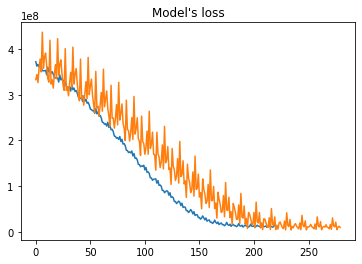

In [387]:
plt.plot(errors_train)
plt.plot(errors_test)

plt.title("Model's loss")
plt.show()